# Random Forest

## Introduction

This notebook focuses on Random Forest to predict binary toxicity in text. As seen in baseline modelling TF-DIF vectorization performed the best in logistic regression, and will be used as the first approach for Random Forest. Count Vectorization may be explored. It was also seen that not including max features in vectorization improved performance of the logistic regression model. In this analysis TF-IDF will be explored to vectorize text for Random Forest. The TF-IDF vectorization will not impose a limit on maximum features, and if computational resources permit, the entire corpus will be vectorized for Random Forest. Class imbalance of the target will also be addressed in this notebook. The data sets train.csv and test_public_expanded.csv will be used. 

## Methodology

This notebook follows the following workflow: 
- Text preprocessing and Vectorization using custom Tokenizer and TF-IDF
- LSA for dimensionality reduction
- Random Forest to predict toxicity, with cross validation and optimization in pipeline
  - weighted class, for class imbalance

## Data Dictionary

### Train DF 
| Column Name   | Description                                      |
|---------------|--------------------------------------------------|
| comment_text  | Text of the comment                              |
| target        | Predicted toxicity score (fraction of annotators who found the comment toxic) |                       
| binary_target | Binary indicator of toxicity (toxic or non-toxic)|

### Test DF
| Column Name   | Description                                      |
|---------------|--------------------------------------------------|
| comment_text  | Text of the comment                              |
| toxicity      | Predicted toxicity score (fraction of annotators who found the comment toxic) |
| binary_target | Binary indicator of toxicity (toxic or non-toxic)|


### Text Processing and Vectorization

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import time
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

In [2]:
train = pd.read_csv('../data/kaggle_bias/train.csv')
test = pd.read_csv('../data/kaggle_bias/test_public_expanded.csv')

In [3]:
train.shape

(1804874, 45)

In [4]:
test.shape

(97320, 45)

In [5]:
print(train['comment_text'].isnull().sum())
test['comment_text'].isnull().sum()

3


0

In [6]:
test.dropna(subset=['comment_text'], inplace=True)
train.dropna(subset=['comment_text'], inplace=True)

**Distribution of Target: Float and binary predictor of toxicity label**

In [7]:
#distribution of target, same as baseline modelling
#Find proportions of y > 0 in train and test,.mean() applied to boolean val will give proportion of True vals
train_percent_tox = (train['target']>0).mean()*100
test_percent_tox = (test['toxicity']>0).mean()*100

print("Percentage of 'target' greater than 0 in train set:", train_percent_tox)
print("Percentage of 'toxicity' greater than 0 in test set:", test_percent_tox)

Percentage of 'target' greater than 0 in train set: 29.92513038327947
Percentage of 'toxicity' greater than 0 in test set: 29.38244965063707


In [8]:
#create binary target
train['binary_target'] = (train['target']>0.5).astype(int)
test['binary_target'] = (test['toxicity']>0.5).astype(int)

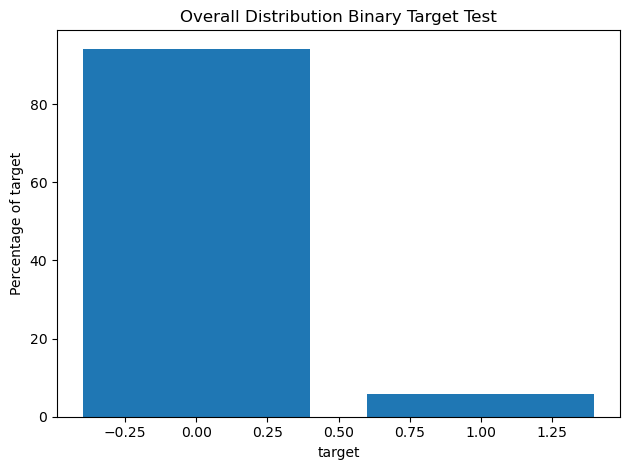

The absolute class distribution is: {0: 91671, 1: 5649}
Count for score 1: 5649
Count for score 0: 91671

The relative (%) class distribution is: 
binary_target
0    94.195438
1     5.804562
Name: proportion, dtype: float64


In [9]:
class_distribution = test['binary_target'].value_counts().to_dict()
overall_count = test['binary_target'].value_counts(normalize=True)*100

plt.bar(overall_count.index, overall_count.values)
plt.title('Overall Distribution Binary Target Test')
plt.xlabel('target')
plt.ylabel('Percentage of target') 

plt.tight_layout()
plt.show()
print(f'The absolute class distribution is:', class_distribution)
print(f'Count for score 1:', class_distribution[1])
print(f'Count for score 0:', class_distribution[0])
print('\nThe relative (%) class distribution is:', f'\n{overall_count}')

**TF-IDF**

In [10]:
def my_tokenizer(document, lemmatization=False, stemming=False, custom_stopwords=None, include_stopwords=None):
    '''
    Function for use in CountVectorizer that tokenizes the document
    '''
    # initialize stop words set within function, changes to stop words stay within function.
    stop_words = set(stopwords.words('english'))

    # remove punctuation and split on spaces, remove /n
    translator = str.maketrans("", "", string.punctuation)
    document = document.translate(translator).replace('\n', ' ')
    tokenized_document = document.lower().split()

    # handle custom stopwords
    #use .discard() to remove certain words from stop words list
    if custom_stopwords is not None:
        # remove custom stop words from stop_words set
        for word_to_remove in custom_stopwords:
            stop_words.discard(word_to_remove)
            
    # include certain words if specified
    # use .update() to add a word to the stop words list
    if include_stopwords is not None:
        stop_words.update(include_stopwords)

    # remove numbers using regular expression
    tokenized_document = [word for word in tokenized_document if not re.match(r'\d+', word)]

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word not in stop_words]

    if stemming:
        stemmed_tokens_list = [PorterStemmer().stem(word) for word in tokenized_document]
        return stemmed_tokens_list

    if lemmatization:
        lemmatized_tokens_list = [WordNetLemmatizer().lemmatize(word) for word in tokenized_document]
        return lemmatized_tokens_list
        
    return tokenized_document

In [11]:
#define X, y train and test
X_train = train['comment_text']
X_test = test['comment_text']
y_train = train['binary_target']
y_test = test['binary_target']

In [12]:
#put tokenizer params into dictionary 
tokenizer_params_default= {'lemmatization':False,
                           'stemming':False,
                           'custom_stopwords':None,
                           'include_stopwords':None}

In [13]:
#instantiate vectorizer: default tokenizer; remove stop words, numbers, punctuation, lower case. 
tfidf_vectorizer = TfidfVectorizer(tokenizer= lambda x:my_tokenizer(x,**tokenizer_params_default),
                                             min_df =10,
                                             ngram_range=(1,2),
                                             max_features = 3000
                                            )

In [14]:
#fit and transform X_train 
start_time = time.time()  #start timer
X_train_transformed = tfidf_vectorizer.fit_transform(X_train)
end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorization took 187.06 seconds


In [15]:
#transform X test
start_time = time.time()  #start timer

X_test_transformed = tfidf_vectorizer.transform(X_test)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 7.48 seconds


### Random Forest

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [17]:
#Define transformer class for LSA
class LSATransformer(TransformerMixin):
    def __init__(self, n_components=100):
        self.n_components = n_components
        self.lsa = TruncatedSVD(n_components=n_components)
    def fit(self, X, y=None):
        self.lsa.fit(X)
        return self
    def transform(self, X):
        return self.lsa.transform(X)

In [18]:
#Use function for grid search
def run_grid_search(X_train, y_train, param_grid, pipeline, scoring_metric, identifier,
                   n_grams='None', vectorization= 'None', max_features= 'None', tokenizer_params= 'default'):
    """
    Run a grid search with the specified parameters.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - param_grid: Parameter grid for the grid search
    - pipeline: pipeline object
    - scoring_metric: Scikit-learn scoring metric
    - identifier: Identifier for iteration of Gridsearch'
    - n_grams: N-gram range used for vectorization (default=None)
    - vectorization: Vectorization technique used (default=None)
    - tokenizer_params: Additional parameters used in the tokenizer (default=None)


    Returns:
    - grid_search: Fitted GridSearchCV object 
    -resluts of cross validation in terms of best params, best score (validation set)
    - time it took to run GridSearch
    """
    #initiate timer module
    start_time = time.time()
   
    # Set up the scoring metric
    scoring =make_scorer(f1_score)

    # Instantiate GridSearchCV with 5-fold cross-validation, n_jobs=3, and specified scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, n_jobs=3)

    # Fit and run grid search
    grid_search.fit(X_train, y_train)

    #end timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Calculate accuracy
    y_pred = grid_search.best_estimator_.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    
     # Store the results (hyperparameters and scores)
    results_list.append({
        'identifier': identifier,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'elapsed_time': elapsed_time,
        'n_grams': n_grams,
        'max_features': max_features,
        'vectorization': vectorization,
        'tokenizer_params': tokenizer_params
    })
    
    # Print the best parameters with the identifier
    print(f"Best Parameters for {identifier}: {grid_search.best_params_}")

    # Print the best score on the validation sets, 
    #.best_score_ is attribute of GridSearch CV that accesses best validation score(score specified in GS)
    print(f"Best {scoring_metric} Score for {identifier}: {grid_search.best_score_}")
    # Print the accuracy
    print(f"Accuracy for {identifier}: {accuracy}")
    # Print the elapsed time
    print(f"Elapsed Time for {identifier}: {elapsed_time} seconds")

    return grid_search

In [19]:
results_list =[]

**GridSearch Run, Identifier = RF_1**
- TF-IDF Vectorization, max features 3000
- LSA n_components = 300
- start with broad param grid for RF

In [20]:
# pipeline = Pipeline([
    #('lsa', LSATransformer(n_components=300)),
    #('rf', RandomForestClassifier(class_weight='balanced',random_state=42, max_features='sqrt')),
#])

In [21]:
#param grid
#param_grid_rf = {
    #'rf__n_estimators': [25, 50, 100],
    #'rf__max_depth': [2, 5, 10],
    #'rf__min_samples_split': [2, 5, 10],
    #'rf__min_samples_leaf': [1, 2, 4],
#}

In [22]:
#scoring_metric = 'F1 Score'
#results_RF_1= run_grid_search(X_train_transformed, y_train, param_grid_rf, pipeline, 
                                 #scoring_metric, 'RF_1', n_grams='(1,2)', vectorization= 'TF-IDF', 
                                 #tokenizer_params= 'default')

Random Forest with Gridsearch on entire vectorized train text is crashing. For now Random Forest will be done without Gridsearch.

In [23]:
#Use LSA to reduce dimensionality, n_component=300 reduce TF-IDF matrix by factor of 10
lsa = TruncatedSVD(n_components=300)
X_train_lsa = lsa.fit_transform(X_train_transformed)
X_test_lsa = lsa.transform(X_test_transformed)

In [24]:
#get feature names out
feature_names = tfidf_vectorizer.get_feature_names_out()

#create mapping of feature names
component_mapping = {}
for i, component in enumerate(lsa.components_):
    top_words_idx = component.argsort()[:-6:-1] #get index of top 5 words
    top_words = [feature_names[idx]for idx in top_words_idx]
    component_mapping[i]= top_words
#print mapping
for component, words in component_mapping.items():
    print(f'Component{component}: {", ".join(words)}')

Component0: people, would, like, one, trump
Component1: trump, president, donald, obama, donald trump
Component2: like, dont, know, people, sounds
Component3: would, like, one, good, sounds
Component4: good, one, well, know, right
Component5: would, dont, know, think, dont know
Component6: good, would, dont, tax, trump
Component7: people, many, white, many people, country
Component8: one, get, people, would, trump
Component9: get, right, well, go, time
Component10: well, said, tax, people, money
Component11: right, tax, youre, thats, state
Component12: well, right, get, us, one
Component13: think, well, dont think, dont, said
Component14: time, go, dont, right, well
Component15: go, im, sure, us, im sure
Component16: know, think, time, im, us
Component17: go, know, think, news, back
Component18: news, time, us, fake, fake news
Component19: thats, time, yes, say, youre
Component20: thats, canada, years, government, party
Component21: much, need, canada, money, really
Component22: much, 

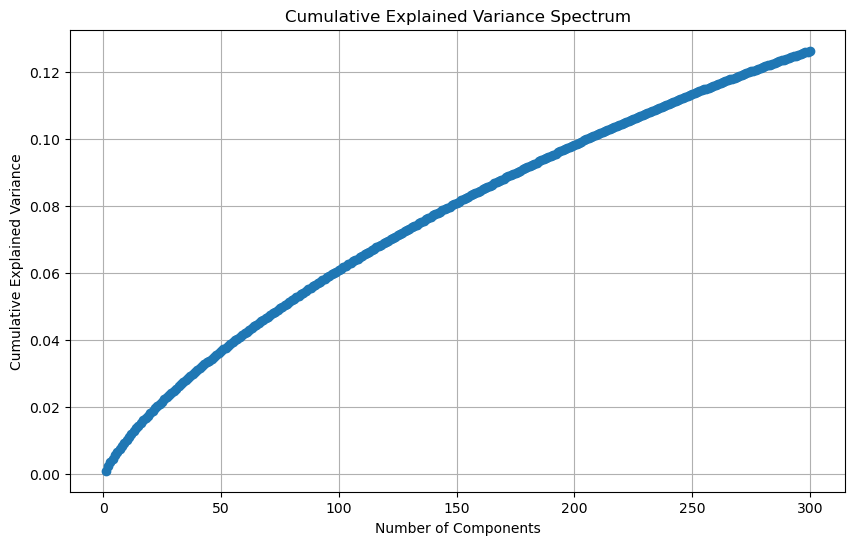

In [61]:
explained_variance_lsa = lsa.explained_variance_
cumulative_explained_variance_lsa = np.cumsum(explained_variance_lsa)

#plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_lsa) + 1), cumulative_explained_variance_lsa, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Spectrum')
plt.grid(True)
plt.show()

LSA to reduce dimensionality: 300 components explain 12% of the total variance in data. 

**Random Forest**

<details>
<summary>Default Parameters for RandomForestClassifier</summary>
n_estimators: 100
criterion: "gini"
max_depth: None
min_samples_split: 2
min_samples_leaf: 1
min_weight_fraction_leaf: 0.0
max_features: "auto"
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_impurity_split: None
bootstrap: True
oob_score: False
n_jobs: None
random_state: None
verbose: 0
warm_start: False
class_weight: None
ccp_alpha: 0.0
max_samples: None
</details>

In [27]:
rf_classifier = RandomForestClassifier(n_jobs= 3, random_state=42,class_weight='balanced')

In [28]:
rf_classifier.fit(X_train_lsa, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=3, random_state=42)

In [29]:
y_pred = rf_classifier.predict(X_test_lsa)

In [33]:
y_pred_train = rf_classifier.predict(X_train_lsa)

In [34]:
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

Training Set Metrics:
Accuracy: 0.9934410824928762
Precision: 0.9153859664529727
Recall: 0.9793025047445462
F1 Score: 0.9462661364998094


In [30]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9423551171393342
Precision: 0.5172109443954104
Recall: 0.10373517436714463
F1 Score: 0.17281038041875554


**Random Forest with 20% Sample of Data, Identifier: rf_sample**

Random Forest will be done with a 20% sample of the data and optimized with grid search. 
- TF-IDF vectorization will be used and no max features set with n-grams (1,2), these vectorization parameters gave best results in baseline log.
- LSA used to reduce dimensionality: n_compoments 100 

In [35]:
#take a sample from the train data set, take stratified sample to maintain distribution. 
sampled_train = train.groupby('binary_target', group_keys=False).apply(lambda x: x.sample(frac=0.2))

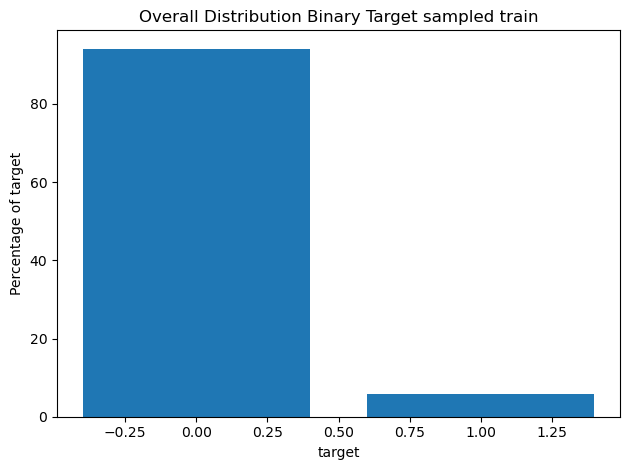

The absolute class distribution is: {0: 339687, 1: 21288}
Count for score 1: 21288
Count for score 0: 339687

The relative (%) class distribution is: 
binary_target
0    94.102639
1     5.897361
Name: proportion, dtype: float64


In [36]:
#check distribution of binary_target in sample is same as overall dataset
class_distribution = sampled_train['binary_target'].value_counts().to_dict()
overall_count = sampled_train['binary_target'].value_counts(normalize=True)*100

plt.bar(overall_count.index, overall_count.values)
plt.title('Overall Distribution Binary Target sampled train')
plt.xlabel('target')
plt.ylabel('Percentage of target') 

plt.tight_layout()
plt.show()
print(f'The absolute class distribution is:', class_distribution)
print(f'Count for score 1:', class_distribution[1])
print(f'Count for score 0:', class_distribution[0])
print('\nThe relative (%) class distribution is:', f'\n{overall_count}')

In [37]:
X_train_sample = sampled_train['comment_text']
y_train_sample = sampled_train['binary_target']

In [38]:
#TF-IDF vectorization, no max features
tfidf_vectorizer1 = TfidfVectorizer(tokenizer= lambda x:my_tokenizer(x,**tokenizer_params_default),
                                             min_df =10,
                                             ngram_range=(1,2),
                                            )

In [39]:
#fit and transform X_train, use .fit_transform() method
start_time = time.time()  #start timer

X_train_transformed_1 = tfidf_vectorizer1.fit_transform(X_train_sample)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorization took 31.84 seconds


In [40]:
start_time = time.time()  #start timer

X_test_transformed_1 = tfidf_vectorizer1.transform(X_test)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 

Vectorization took 7.62 seconds


In [42]:
X_train_transformed_1.shape[1]

117600

In [49]:
##Use LSA to reduce dimensionality, n_component=100 reduce TF-IDF matrix by factor of 10
lsa_1 = TruncatedSVD(n_components=100)
X_train_lsa_1 = lsa_1.fit_transform(X_train_transformed_1)
X_test_lsa_1 = lsa_1.transform(X_test_transformed_1)

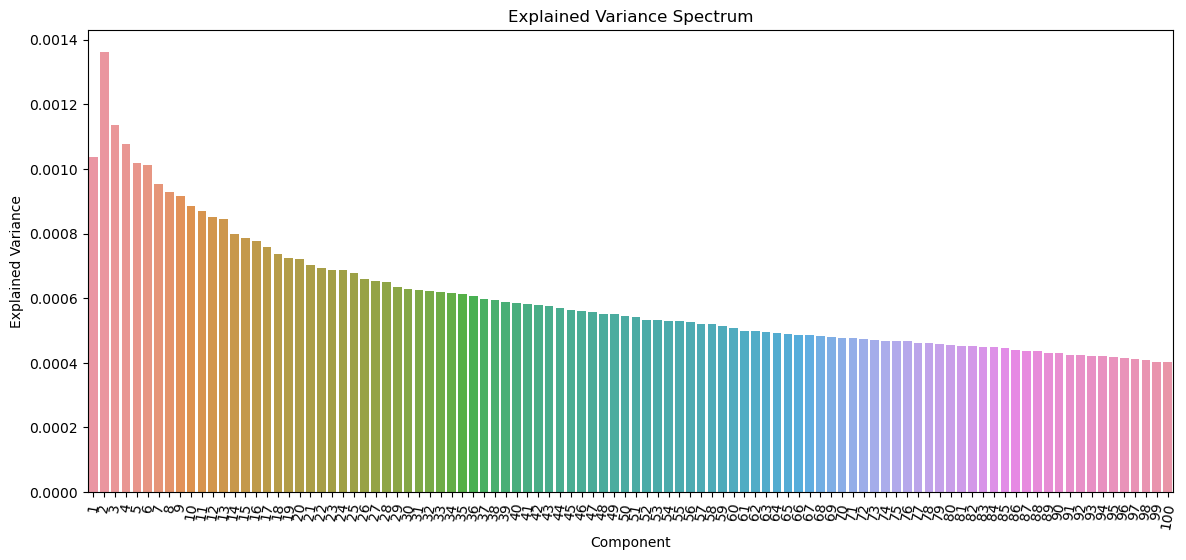

In [55]:
explained_variance = lsa_1.explained_variance_

plt.figure(figsize=(14, 6))
sns.barplot(x=list(range(len(explained_variance))), y=explained_variance)
plt.xlabel('Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Spectrum')

# Set x-axis ticks
plt.xticks(ticks=range(len(explained_variance)), labels=range(1, len(explained_variance)+1), rotation=80)

plt.show()

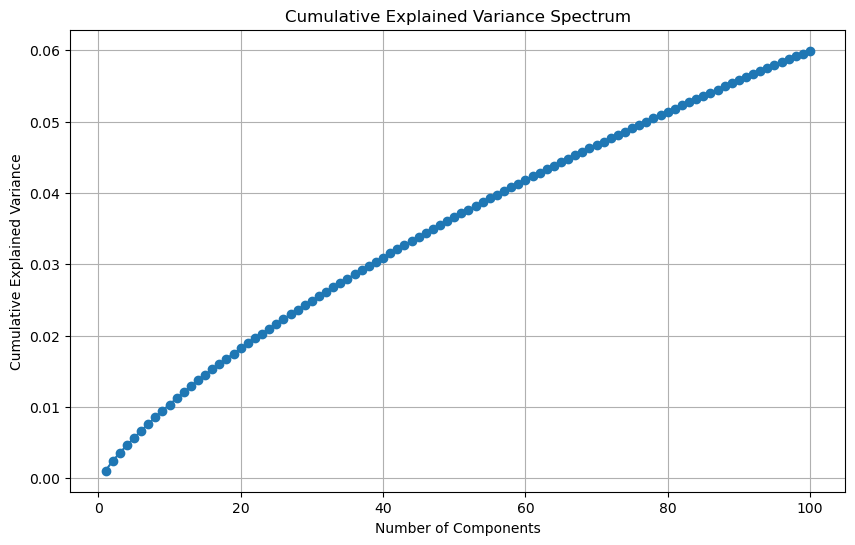

In [57]:
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Spectrum')
plt.grid(True)
plt.show()

In [63]:
#random forest
pipeline = Pipeline([
    ('rf', RandomForestClassifier(class_weight='balanced',random_state=42, max_features='sqrt')),
])

In [62]:
#param grid
param_grid_rf = {
    'rf__n_estimators': [25, 50, 100],
    'rf__max_depth': [2, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

In [64]:
scoring_metric = 'F1 Score'
results_rf_sample= run_grid_search(X_train_lsa_1, y_train_sample, param_grid_rf, pipeline, 
                                 scoring_metric, 'rf_sample', n_grams='(1,2)', vectorization= 'TF-IDF', 
                                 tokenizer_params= 'default')

Best Parameters for rf_sample: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best F1 Score Score for rf_sample: 0.20542546002441187
Accuracy for rf_sample: 0.8016898677193711
Elapsed Time for rf_sample: 9554.09103012085 seconds


In [65]:
#get best model and predict
rf_sample_model = results_rf_sample.best_estimator_
y_pred_rf_sample = rf_sample_model.predict(X_test_lsa_1)

In [66]:
#look at metrics
accuracy_rf_sample = accuracy_score(y_test, y_pred_rf_sample)
precision_rf_sample = precision_score(y_test, y_pred_rf_sample)
recall_rf_sample = recall_score(y_test, y_pred_rf_sample)
f1_rf_sample = f1_score(y_test, y_pred_rf_sample)

print('Metrics rf_sample')
print(f"Accuracy: {accuracy_rf_sample}, Precision: {precision_rf_sample}, Recall: {recall_rf_sample}, F1 Score: {f1_rf_sample}")

Metrics rf_sample
Accuracy: 0.7851931771475544, Precision: 0.12750268580916105, Recall: 0.46220570012391576, F1 Score: 0.19986986642170934


# Results and Summary

The results of random forest show lower scores than the best baseline logistic regression model. Parameters could be optimized further and LSA component number could also be adjusted. Random Forest could also be done without LSA. For the purpose of this analysis further optimization of the random forest model may be revisited. Moving forward DistilBERT will be evaluated for classification of toxicity using this data set. 